In [188]:
from data import InkmlDataset_PL
from models.lstm_ctc import LSTM_TemporalClassification_PL
from torchaudio.models.decoder import ctc_decoder, cuda_ctc_decoder
import matplotlib.pyplot as plt
import numpy as np
from data import *
from torchmetrics.text import EditDistance

# model = LSTM_TemporalClassification_PL().load_from_checkpoint("logs/lstm_ctc/version_1/checkpoints/epoch=22-step=20470.ckpt")
model = LSTM_TemporalClassification_PL(num_layers=3).load_from_checkpoint(
    "logs/lstm_ctc/version_3/checkpoints/epoch=22-step=20470.ckpt"
)
dm = InkmlDataset_PL(root_dir="dataset/crohme2019")
dm.setup()
# Set the model to evaluation mode
model.eval()

LSTM_TemporalClassification_PL(
  (model): LSTM_TemporalClassification(
    (lstm): LSTM(4, 256, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=512, out_features=109, bias=True)
    (log_softmax): LogSoftmax(dim=2)
  )
  (criterion): CTCLoss()
  (metric): EditDistance()
)

In [189]:
tokens = list(model.vocab.keys())
beam_search_cuda = cuda_ctc_decoder(tokens=tokens, nbest=1)
beam_search = ctc_decoder(
    tokens=tokens, lexicon=None, nbest=1, blank_token="", sil_token=""
)

x Right = Right r Right \cos Right \theta


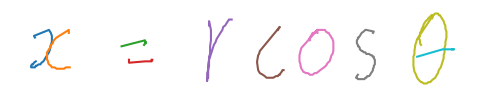

In [190]:
# x, y, lenx, leny = dm.test_dataset.__getitem__(0)
path = "dataset/crohme2019/crohme2019/train/65_miguel.inkml"
ink = Inkml(path)

traces = ink.getTraces()
combined_traces = np.vstack([np.array(trace)[:, :2] for trace in traces])
delta_traces = np.diff(combined_traces, axis=0)
zeros_filter = np.all(delta_traces == 0, axis=1)
delta_traces = delta_traces[~zeros_filter]
distance = np.sqrt((np.square(delta_traces[:, 0]) + np.square(delta_traces[:, 1])))[
    :, np.newaxis
]
delta_traces = (
    delta_traces / distance
)  # delta x, delta y --> delta x/sqrt(delta x^2 + delta y^2), delta y/sqrt(delta x^2 + delta y^2

pen_up = [np.array([0] * len(trace)) for trace in traces]
for _, arr in enumerate(pen_up):
    arr[0] = 1

combined_pen_up = np.concatenate(pen_up)[1:, np.newaxis][~zeros_filter]
combined_traces = np.hstack([delta_traces, distance, combined_pen_up])
delta_traces_tensor = torch.tensor(combined_traces, dtype=torch.float32)

# item = dm.train_dataset.__getitem__(6)

output = model(delta_traces_tensor.unsqueeze(0).cuda())
output.shape

len_tensor = torch.tensor([output.shape[1]], dtype=torch.int32).cuda()
decoded_output = beam_search_cuda(output, len_tensor.to(torch.int32))
# print([np.array(trace)[:, :2].shape for trace in ink.getTraces()])

output_str = " ".join(decoded_output[0][0].words)
print(output_str)

plt.figure(figsize=(6, 1))
# plt.rcParams["axes.facecolor"] = "black"  # Set background color to black
plt.axis("off")
for trace in ink.getTraces():
    trace_arr = np.array(trace)
    plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate

In [191]:
decoded_output_cpu = beam_search(output.cpu())[0][0]

timesteps = list(decoded_output_cpu.timesteps.cpu().numpy()) + [output.shape[1]]
timesteps[0] = 0
timesteps_interval = [timesteps[i : i + 2] for i in range(len(timesteps) - 1)]


indices = decoded_output_cpu.tokens.cpu().numpy()
normal_prob = np.exp(
    output.squeeze(0).cpu().detach().numpy()
)  # [timesteps, vocab_size]
word_list = decoded_output[0][0].words


prob_interval = [
    normal_prob[timestep_interval[0] : timestep_interval[1]]
    for timestep_interval in timesteps_interval
]
prob_by_index = np.concatenate(
    [prob[:, indices[i]] for i, prob in enumerate(prob_interval)]
)

In [195]:
print(word_list, len(word_list))
print(timesteps_interval, len(timesteps_interval))
print(timesteps)
print(len(prob_by_index))

['x', 'Right', '=', 'Right', 'r', 'Right', '\\cos', 'Right', '\\theta'] 9
[[0, 58], [58, 59], [59, 76], [76, 77], [77, 120], [120, 121], [121, 255], [255, 256], [256, 332]] 9
[0, 58, 59, 76, 77, 120, 121, 255, 256, 332]
332


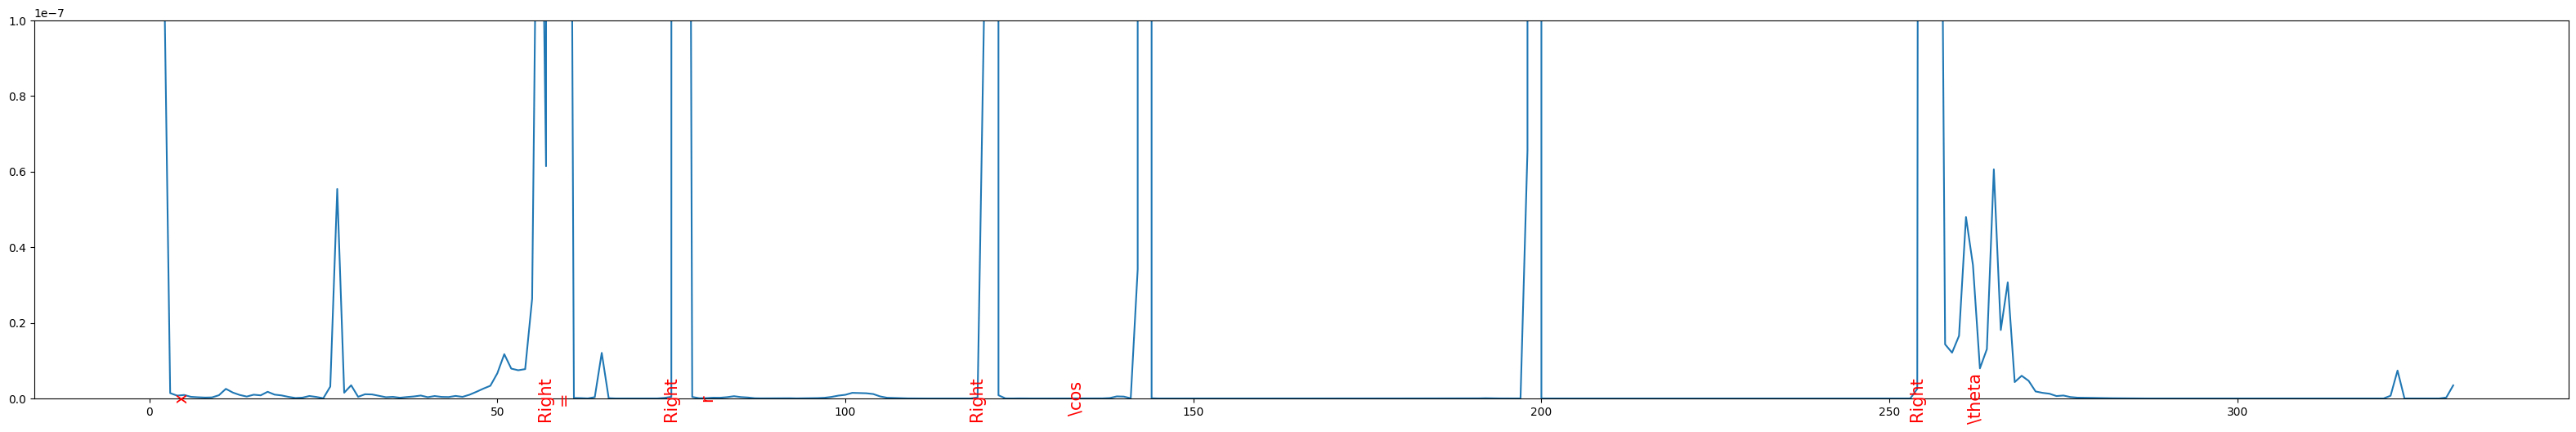

In [208]:
plt.figure(figsize=(40, 6))
for i, word in enumerate(word_list):
    plt.text(
        (0.9 * timesteps_interval[i][0] + 0.1 * timesteps_interval[i][1]),
        0,
        word,
        rotation=90,
        ha="center",
        va="bottom",
        rotation_mode="anchor",
        verticalalignment="top",
        color="red",
        fontsize=15,
    )

plt.plot(prob_by_index)

plt.ylim(0, 0.0000001)
plt.show()